In [1]:
import os
cur_dir = os.getcwd()
result_dir = os.path.join(cur_dir, '..', '..', 'results')

path_dict = {
    "train": {
        "los": os.path.join(result_dir, 'integrated_gradients', 'full', 'train_dataset', 'IG_abs_los_mean_step400_1_global_importance.csv'),
        "x": os.path.join(result_dir, 'integrated_gradients', 'full', 'train_dataset', 'IG_abs_x_mean_step400_1_global_importance.csv')
    },
    "val": {
        "los": os.path.join(result_dir, 'integrated_gradients', 'full', 'val_dataset', 'IG_abs_los_mean_step400_1_global_importance.csv'),
        "x": os.path.join(result_dir, 'integrated_gradients', 'full', 'val_dataset', 'IG_abs_x_mean_step400_1_global_importance.csv')
    },
    "test": {
        "los": os.path.join(result_dir, 'integrated_gradients', 'full', 'test_dataset', 'IG_abs_los_mean_step400_1_global_importance.csv'),
        "x": os.path.join(result_dir, 'integrated_gradients', 'full', 'test_dataset', 'IG_abs_x_mean_step400_1_global_importance.csv')
    }
}

In [2]:
import os
import pandas as pd


def _change_df(df: pd.DataFrame):
    df = df[['idx', 'name', 'mean', 'rank_mean']]
    # full result only calculates IG once: 
    # no need std related column [std, mean_minus_std, mean_plus_std, cv]
    # column name 'mean' has to be changed into 'value'
    df = df.rename(columns={'mean': 'IG_share', 'rank_mean': 'rank'})
    return df


def _merge_df(x_df, los_df, filename):
    cur_dir = os.getcwd()
    path = os.path.join(cur_dir, filename)

    combined_df = pd.concat([x_df, los_df], ignore_index=True)
    combined_df = _change_df(combined_df)
    combined_df = combined_df.sort_values(by=['IG_share'], ascending=False, ignore_index=True)
    combined_df.to_csv(path)

    return combined_df

def merge_df(path_dict: dict):
    ig_full_df_dict = {}
    for key, value in path_dict.items():
        x_ig_df = pd.read_csv(value['x'])
        los_ig_df = pd.read_csv(value['los'])
        filename = key + "_ig_full.csv"
        combined_df = _merge_df(x_ig_df, los_ig_df, filename)
        
        ig_full_df_dict[key] = combined_df

    
    return ig_full_df_dict

ig_full_df_dict = merge_df(path_dict)

In [3]:
print("Checking IG_share: Does it sum to 1?")
print(f"train: {ig_full_df_dict['train']['IG_share'].sum()}")
print(f"val: {ig_full_df_dict['val']['IG_share'].sum()}")
print(f"test: {ig_full_df_dict['test']['IG_share'].sum()}")


Checking IG_share: Does it sum to 1?
train: 1.0000000040745327
val: 1.0000000033760408
test: 0.9999999986030126


In [4]:
import pandas as pd
import numpy as np

# Duplicate index values (idx=0 for both LOS and STFIPS) triggered a many-to-many join,
# leading to duplicated IG_share_train entries and an incorrect total share (>1).
# We resolve this by matching variables via the 'name' column and rebuilding
# globally unique indices using COLNAMES.

"""
Train Set Size: 975896
Valid Set Size: 209119
Test Set Size: 209123
"""

dataset_size_dict = {
    'train': 975896,
    'val': 209119,
    'test': 209123,
}
def merge_mean_share_by_name(df_dict, sizes, share_col="IG_share", name_col="name"):
    t  = df_dict["train"][[name_col, share_col]].rename(columns={share_col: f"{share_col}_train"})
    v  = df_dict["val"]  [[name_col, share_col]].rename(columns={share_col: f"{share_col}_val"})
    te = df_dict["test"] [[name_col, share_col]].rename(columns={share_col: f"{share_col}_test"})

    # name uniqueness check
    for split, d in [("train", t), ("val", v), ("test", te)]:
        if d.duplicated(name_col).any():
            bad = d[d.duplicated(name_col, keep=False)].sort_values(name_col)
            raise ValueError(f"{split}: duplicated '{name_col}' exists:\n{bad}")

    merged = t.merge(v, on=name_col, how="outer").merge(te, on=name_col, how="outer")

    share_cols = [f"{share_col}_train", f"{share_col}_val", f"{share_col}_test"]
    if merged[share_cols].isna().any(axis=1).any():
        bad = merged[merged[share_cols].isna().any(axis=1)]
        raise ValueError(f"Missing shares after merge. Example:\n{bad.head(20)}")

    w_train, w_val, w_test = float(sizes["train"]), float(sizes["val"]), float(sizes["test"])
    w_sum = w_train + w_val + w_test

    merged["IG_share_all"] = (
        merged[f"{share_col}_train"]*w_train +
        merged[f"{share_col}_val"]*w_val +
        merged[f"{share_col}_test"]*w_test
    ) / w_sum

    merged["rank_all"] = merged["IG_share_all"].rank(ascending=False, method="min").astype(int)
    merged = merged.sort_values(["rank_all", name_col]).reset_index(drop=True)
    return merged

def reindex_with_global_idx(df, col_names, los_name="LOS", name_col="name"):
    """
    col_names: 길이 72짜리 리스트 (x 변수들)
    결과: x 변수 idx=0..71, LOS idx=72 로 전역 유일하게 재부여
    """
    df = df.copy()

    name_to_idx = {n: i for i, n in enumerate(col_names)}
    los_idx = len(col_names)

    def _map_idx(n):
        if n == los_name:
            return los_idx
        if n in name_to_idx:
            return name_to_idx[n]
        raise ValueError(f"Unknown variable name '{n}' not in col_names and not LOS.")

    df["idx"] = df[name_col].map(_map_idx)
    return df

def diagnose_key_uniqueness(df, key="idx", name="df"):
    dup = df[df.duplicated(key, keep=False)].sort_values(key)
    print(f"[{name}] rows={len(df)}, unique {key}={df[key].nunique()}")
    print(f"[{name}] duplicated {key} rows={len(dup)}")
    if len(dup) > 0:
        print(dup[[key, "name", "IG_share", "rank"]].head(20))


full_dataset_df = merge_mean_share_by_name(ig_full_df_dict, dataset_size_dict)

COLNAMES = ['STFIPS', 'EDUC', 'MARSTAT', 'SERVICES', 'DETCRIM', 'PSOURCE', 'NOPRIOR', 'ARRESTS', 'EMPLOY', 'METHUSE', 'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'SERVICES_D', 'EMPLOY_D', 'LIVARAG_D', 'ARRESTS_D', 'DSMCRIT', 'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'DETNLF_D', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3', 'SUB1_D', 'SUB2_D', 'SUB3_D', 'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FREQ1_D', 'FREQ2_D', 'FREQ3_D', 'FRSTUSE1', 'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP', 'FREQ_ATND_SELF_HELP_D', 'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG', 'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG', 'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG', 'DIVISION', 'REGION', 'IDU', 'ALCDRUG', 'CBSA2020']
full_dataset_df = reindex_with_global_idx(full_dataset_df, COLNAMES)

diagnose_key_uniqueness(ig_full_df_dict["train"], key="idx", name="train")
diagnose_key_uniqueness(ig_full_df_dict["val"],   key="idx", name="val")
diagnose_key_uniqueness(ig_full_df_dict["test"],  key="idx", name="test")
diagnose_key_uniqueness(full_dataset_df,  key="idx", name="full")

save_df = full_dataset_df.copy()
save_df = save_df[['name', 'IG_share_all', 'rank_all']]
save_df.to_csv(os.path.join(cur_dir, "full_dataset_IG_result.csv"))


[train] rows=73, unique idx=72
[train] duplicated idx rows=2
    idx    name  IG_share  rank
25    0     LOS  0.015717     1
52    0  STFIPS  0.009344    52
[val] rows=73, unique idx=72
[val] duplicated idx rows=2
    idx    name  IG_share  rank
25    0     LOS  0.015698     1
52    0  STFIPS  0.009323    52
[test] rows=73, unique idx=72
[test] duplicated idx rows=2
    idx    name  IG_share  rank
24    0     LOS  0.015764     1
52    0  STFIPS  0.009331    52
[full] rows=73, unique idx=73
[full] duplicated idx rows=0


In [5]:
print("train sum:", ig_full_df_dict["train"]["IG_share"].sum())
print("val sum:",   ig_full_df_dict["val"]["IG_share"].sum())
print("test sum:",  ig_full_df_dict["test"]["IG_share"].sum())

print("merged train sum:", full_dataset_df["IG_share_train"].sum())
print("merged val sum:",   full_dataset_df["IG_share_val"].sum())
print("merged test sum:",  full_dataset_df["IG_share_test"].sum())
print("merged all sum:",   full_dataset_df["IG_share_all"].sum())


train sum: 1.0000000040745327
val sum: 1.0000000033760408
test sum: 0.9999999986030126
merged train sum: 1.0000000040745327
merged val sum: 1.0000000033760408
merged test sum: 0.9999999986030128
merged all sum: 1.0000000031490226


In [6]:
full_dataset_df

,name,IG_share_train,IG_share_val,IG_share_test,IG_share_all,rank_all,idx
0,ARRESTS_D,0.036514,0.036461,0.036478,0.036501,1,19
1,DIVISION,0.029552,0.029601,0.029536,0.029557,2,67
2,DSMCRIT,0.027375,0.027390,0.027374,0.027377,3,20
3,REGION,0.026388,0.026400,0.026365,0.026387,4,68
4,FREQ1_D,0.026335,0.026331,0.026323,0.026332,5,39
...,...,...,...,...,...,...,...
68,SUB1,0.003099,0.003086,0.003097,0.003097,69,27
69,SUB2,0.002118,0.002117,0.002116,0.002118,70,28
70,FREQ_ATND_SELF_HELP,0.001916,0.001906,0.001910,0.001913,71,47
71,SUB3,0.001597,0.001598,0.001591,0.001596,72,29


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ig_with_cumulative(
    df,
    share_col="IG_share",
    name_col="name",
    top_k=None,
    figsize=(12, 10),
):
    """
    Bar + cumulative IG share plot with 60% / 80% thresholds
    """

    # --- sort ---
    plot_df = df.sort_values(share_col, ascending=False).copy()

    if top_k is not None:
        plot_df = plot_df.head(top_k)

    shares = plot_df[share_col].values
    names = plot_df[name_col].values

    cumulative = np.cumsum(shares)

    fig, ax1 = plt.subplots(figsize=figsize)

    # --- bar plot ---
    ax1.bar(range(len(shares)), shares)
    ax1.set_ylabel("IG Share")
    ax1.set_xticks(range(len(names)))
    ax1.set_xticklabels(names, rotation=90)

    # --- cumulative line ---
    ax2 = ax1.twinx()
    ax2.plot(range(len(cumulative)), cumulative, marker="o", color="black")
    ax2.set_ylabel("Cumulative Share")
    ax2.set_ylim(0, max(1.1, cumulative.max()))

    # --- thresholds ---
    for thr, color in [(0.6, "orange"), (0.8, "red")]:

        ax2.axhline(thr, linestyle="--", color=color, alpha=0.7)

        idx = np.argmax(cumulative >= thr)

        if cumulative[idx] >= thr:
            ax2.axvline(idx, linestyle=":", color=color, alpha=0.7)

            ax2.text(
                idx,
                thr,
                f"  {int(thr*100)}% @ {idx+1}",
                color=color,
                va="bottom",
            )

    plt.title("IG Share + Cumulative Contribution")

    plt.tight_layout()
    plt.show()


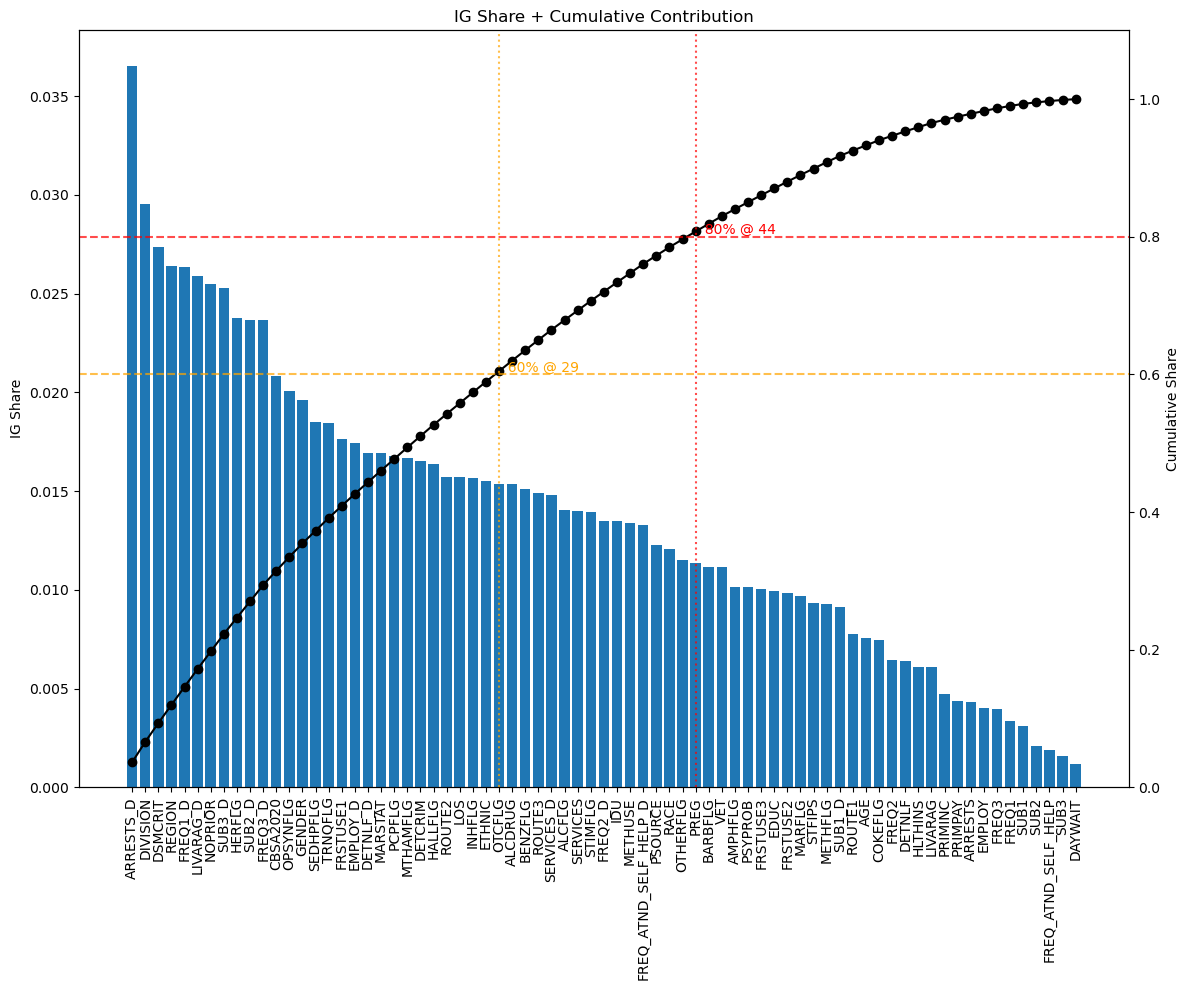

In [8]:
plot_ig_with_cumulative(full_dataset_df, share_col='IG_share_all')

In [9]:
import os
import pandas as pd
cur_dir = os.getcwd()
raw_path = os.path.join(cur_dir, '..', '..', '..', 'data', 'raw', 'missing_corrected.csv')
df = pd.read_csv(raw_path)
df['REASONb'] = np.where(df['REASON'] == 1, 1, 0)
df = df.drop(['REASON'], axis=1)

In [10]:
df['ARRESTS_D'].value_counts() / df.shape[0]

ARRESTS_D
 0    0.758969
-9    0.192990
 1    0.033814
 2    0.014227
Name: count, dtype: float64

In [11]:
print(df['REASONb'][df['ARRESTS_D'] == -9].value_counts() / sum(df['ARRESTS_D'] == -9))
print(df['REASONb'][df['ARRESTS_D'] == 0].value_counts() / sum(df['ARRESTS_D'] == 0))
print(df['REASONb'][df['ARRESTS_D'] == 1].value_counts() / sum(df['ARRESTS_D'] == 1))
print(df['REASONb'][df['ARRESTS_D'] == 2].value_counts() / sum(df['ARRESTS_D'] == 2))

REASONb
0    0.512834
1    0.487166
Name: count, dtype: float64
REASONb
0    0.568959
1    0.431041
Name: count, dtype: float64
REASONb
0    0.599096
1    0.400904
Name: count, dtype: float64
REASONb
1    0.667053
0    0.332947
Name: count, dtype: float64
